In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import math as tfm
import numpy as np
import matplotlib.pyplot as plt

2024-05-22 12:34:46.048219: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 12:34:46.079305: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 12:34:46.079911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 12:34:46.827180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [83]:
# Define the kernel (covariance function)
amplitude = tfp.util.TransformedVariable(
            1.0, tfp.bijectors.Softplus(), dtype=np.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
            1.0, tfp.bijectors.Softplus(), dtype=np.float64, name='length_scale')
kernel = tfm.psd_kernels.ExponentiatedQuadratic(amplitude=amplitude, length_scale=length_scale, feature_ndims=1)

# Define the index points (input data)
num_points = 100
dimension = 5
index_points = np.expand_dims(np.tile(np.linspace(-5., 5., num_points).reshape(1, -1), (dimension, 1)).T, axis=-1)

# Define the mean function
mean_fn = lambda x: tf.zeros_like(x[..., 0])

# Define the Student's t-process
df = 3.0  # degrees of freedom
tp = tfp.distributions.StudentTProcess(
    df=df,
    kernel=kernel,
    index_points=index_points,
    mean_fn=mean_fn,
    always_yield_multivariate_student_t=True,
)

In [84]:
print(f'Index points shape: {index_points.shape}')
print(f'Minimum index point: {index_points.min()}')
print(f'Maximum index point: {index_points.max()}')

Index points shape: (100, 5, 1)
Minimum index point: -5.0
Maximum index point: 5.0


In [88]:
# Sample from the prior
num_samples = 10
samples = tp.sample(num_samples)
print(f'Samples shape: {samples.shape}')
print(f'Mean shape: {tf.reduce_mean(samples, axis=0).shape}')
print(f'Minimum value: {tf.reduce_min(samples)}')
print(f'Maximum value: {tf.reduce_max(samples)}')

Samples shape: (10, 100, 5)
Mean shape: (100, 5)
Minimum value: -4.960052388345568
Maximum value: 12.117877149008079


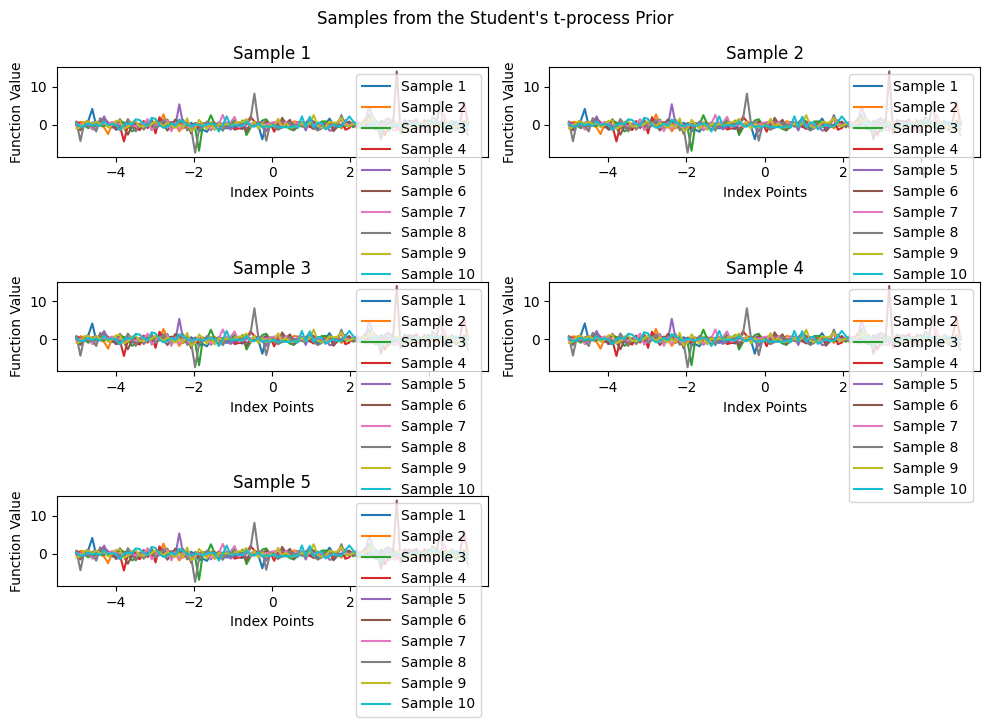

In [87]:
# Plot the samples with 5 subplots
plt.figure(figsize=(10, 10))
for i in range(dimension):
    plt.subplot(5, 2, i+1)
    for j in range(num_samples):
        plt.plot(index_points[:, 0], samples[j, :, i], label=f'Sample {j+1}')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Index Points')
    plt.ylabel('Function Value')
    plt.legend()
plt.tight_layout()
plt.suptitle('Samples from the Student\'s t-process Prior', y=1.02)
plt.show()

In [56]:
y = np.linspace(0., 100., len(index_points)).reshape(-1, 1)
print(f'Y shape: {y.shape}')

# Compute the log probability of the samples
log_prob = tp.log_prob(samples)
print(f'Log probability shape: {log_prob.shape}')
print(f'Minimum log probability: {tf.reduce_min(log_prob)}')

# Get the posterior predictive distribution
posterior_predictive = tp.posterior_predictive(y, samples)
y_posterior = posterior_predictive.sample(1)

print(f'Posterior predictive shape: {posterior_predictive.y_posterior}')
print(f'Minimum posterior predictive: {tf.reduce_min(y_posterior)}')
print(f'Maximum posterior predictive: {tf.reduce_max(y_posterior)}')

Y shape: (5, 1)
Log probability shape: (100,)
Minimum log probability: 2.8550120021087517


InvalidArgumentError: {{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Matrix size-incompatible: In[0]: [100,5], In[1]: [5,100] [Op:MatMul] name: 

In [109]:
# Define some observed data (noisy observations from a sinusoidal function)
observed_index_points = np.array([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 1.0]).reshape(-1, 1)
observed_values = np.sin(observed_index_points) + np.random.normal(0, 0.1, observed_index_points.shape)

# Define the observation noise variance
observation_noise_variance = 0.1

In [110]:
print(observed_index_points.shape)
print(observed_values.shape)

(10, 1)
(10, 1)


In [111]:
print(tp.covariance().shape)
print(tp.mean().shape)
print(tp.stddev().shape)

(100, 100)
(100,)
(100,)


In [113]:
tp_posterior = tp.posterior_predictive(observations=observed_values, predictive_index_points=index_points, observation_index_points=observed_index_points, observation_noise_variance=observation_noise_variance)
posterior_samples = tp_posterior.sample(10)

ValueError: Dimensions 10 and 1 are not compatible

In [114]:
# Define some observed data (noisy observations from a sinusoidal function)
observed_index_points = np.array([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]).reshape(-1, 1)

observed_values = np.sin(observed_index_points) + np.random.normal(0, 0.1, observed_index_points.shape)

# Define the observation noise variance
observation_noise_variance = 0.1

# Condition the process on the observed data
tp_posterior = tp.posterior_predictive(predictive_index_points=observed_index_points, observations=observed_values, observation_noise_variance=observation_noise_variance)

# Sample from the posterior
posterior_samples = tp_posterior.sample(10)

# Plot the posterior samples
plt.figure(figsize=(10, 6))
for i in range(num_samples):
    plt.plot(index_points, posterior_samples[i], label=f'Posterior Sample {i+1}', alpha=0.6)
plt.scatter(observed_index_points, observed_values, c='red', label='Observed Data')
plt.title('Samples from the Student\'s t-process Posterior')
plt.xlabel('Index Points')
plt.ylabel('Function Value')
plt.legend()
plt.show()



ValueError: Dimensions 100 and 1 are not compatible